## Imports

In [78]:
import eduanalytics
from eduanalytics import model_data, pipeline_tools, reporting

In [79]:
import re, os, sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

## Explore results

In [80]:
path = eduanalytics.credentials_path
group = eduanalytics.credentials_group

engine = model_data.connect_to_database(path, group)

In [81]:
tbl_name = 'worry_score_admissions'

In [82]:
results = model_data.get_data_for_modeling(engine, 
            tbl_name, status = 'predictions')

In [83]:
train = results[results.set == 'train']
test = results[results.set == 'test']

In [84]:
print(train.outcome.value_counts())
print(train.shape)

0.0    764
1.0     98
Name: outcome, dtype: int64
(862, 4)


In [85]:
print(test.outcome.value_counts())
print(test.shape)

0.0    377
1.0     49
Name: outcome, dtype: int64
(426, 4)


In [86]:
27/322

0.08385093167701864

In [87]:
pkl_path = '/Volumes/IIME/EDS/data/admissions/pkls'

In [88]:
grid_search = reporting.load_model(pkl_path, tbl_name, 'rf_grid')

In [89]:
grid_search

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('dummyencoder', DummyEncoder()), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=N...imators=10, n_jobs=1, oob_score=False, random_state=1100,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [10, 50, 100, 200, 500, 1000], 'randomforestclassifier__max_depth': [1, 5, 10, 20, 50], 'randomforestclassifier__max_features': ['sqrt', 'log2'], 'randomforestclassifier__min_samples_split': [2, 5, 10], 'imputer__strategy': ['mean', 'median']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [90]:
risk_scores = test.predicted
hard_predictions = [1 if score >= 0.5 else 0 for score in risk_scores]

In [91]:
49/426

0.11502347417840375

In [92]:
percentages = [8, 12]
hard_predictions_t1 = reporting.generate_binary_at_k(risk_scores, percentages[0])
hard_predictions_t2 = reporting.generate_binary_at_k(risk_scores, percentages[1])

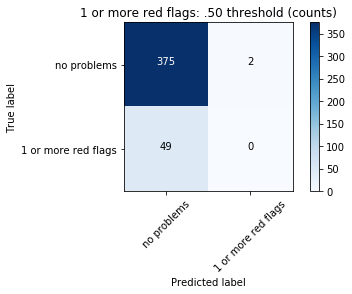

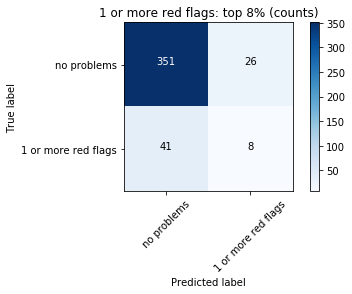

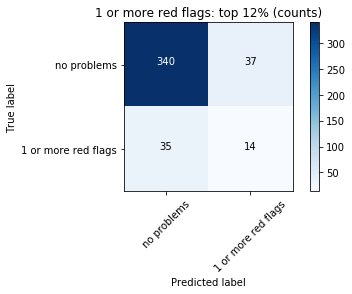

In [93]:
# Compute confusion matrix
class_names = ['no problems', '1 or more red flags']

labels = ['.50 threshold', 'top {}%'.format(percentages[0]), 'top {}%'.format(percentages[1])]
plots = zip([hard_predictions, hard_predictions_t1, hard_predictions_t2], labels)
title = class_names[1]

# Plot confusion matrix with counts
for predictions, label in plots:
    plt.figure()
    reporting.build_confusion_matrix(
    test.outcome, predictions, 
    class_names, 
    '{}: {}'.format(title, label))

plt.show()

In [94]:
forest = pipeline_tools.extract_model_from_pipeline(grid_search)
print(type(forest))

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [95]:
transformed_columns = pipeline_tools.get_transformed_columns(grid_search)

In [96]:
importances, std, indices = reporting.compute_feature_importances_ensemble(
    forest, transformed_columns)

1: median_income_zipcode = 0.063
2: total_percentile = 0.056
3: bio_percentile = 0.050
4: bcpm_a_counts = 0.048
5: bcpm_hours_cumulative = 0.047
6: bcpm_gpa_cumulative = 0.040
7: total_gpa_cumulative = 0.038
8: phy_chem_percentile = 0.036
9: biol_b_counts = 0.035
10: bcpm_b_counts = 0.034
11: biol_a_counts = 0.033
12: chem_a_counts = 0.030
13: parent_edu_score = 0.029
14: bcpm_gpa_postbac = 0.023
15: num_schools_accepted_to = 0.020
16: age_at_application = 0.020
17: total_gpa_postbac = 0.020
18: chem_b_counts = 0.019
19: math_b_counts = 0.017
20: phys_a_counts = 0.017
21: math_a_counts = 0.017
22: phys_b_counts = 0.015
23: bcpm_c_counts = 0.014
24: appl_year_2009.0 = 0.013
25: gender_M = 0.013
26: is_disadvantaged_1.0 = 0.013
27: appl_year_2010.0 = 0.011
28: total_gpa_soph_higher_nan = 0.010
29: race_Chinese = 0.009
30: bcpm_gpa_juni_higher_1.0 = 0.009
31: exp_medical_1.0 = 0.008
32: total_gpa_seni_higher_1.0 = 0.008
33: bcpm_gpa_seni_higher_nan = 0.008
34: chem_c_counts = 0.007
35: to

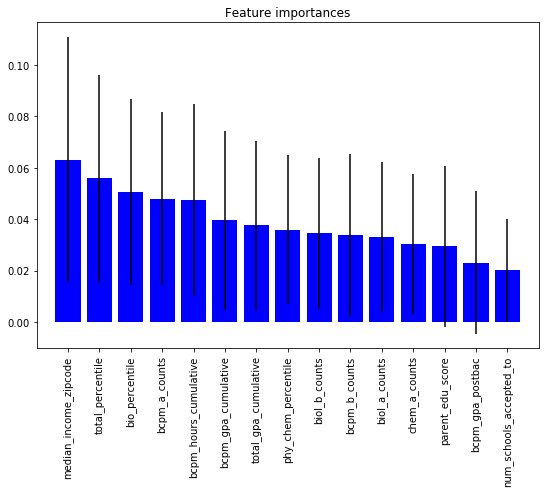

In [97]:
# Plot the feature importances of the forest
plt.figure(figsize=(9,6))
reporting.plot_feature_importances(
    importances, std, indices, transformed_columns)

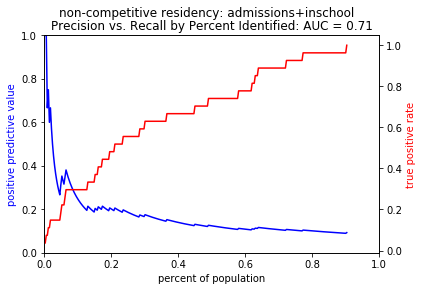

In [32]:
outcome = 'non-competitive residency'
features = 'admissions+inschool'
reporting.plot_precision_recall_n(test.outcome, risk_scores, '{}: {}'.format(outcome, features))

In [31]:
metrics.roc_auc_score(test.outcome, risk_scores)

0.71198995605775262

In [ ]:
# TODO: Figure out how to output to database
# TODO: Figure out sklearn2pmml
# TODO: Multiclass classification
# TODO: Compare classifiers (logistic regression?)
# TODO: Incorporate lime
# TODO: Incorporate autosklearn?